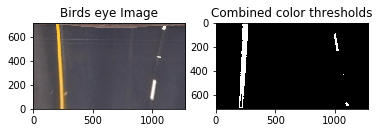

In [6]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque

class Line:
    def __init__(self, region):
        # Was the line found in the previous frame?
        self.found = False
        self.region = region
        
        # Remember x and y values of lanes in previous frame
        self.X = None
        self.Y = None
        
        # Store recent x intercepts for averaging across frames
        self.x_int = deque(maxlen=10)
        self.top = deque(maxlen=10)
        
        # Remember previous x intercept to compare against current one
        self.lastx_int = None
        self.last_top = None
        
        # Remember radius of curvature
        self.radius = None
        
        # Store recent polynomial coefficients for averaging across frames
        self.fit0 = deque(maxlen=10)
        self.fit1 = deque(maxlen=10)
        self.fit2 = deque(maxlen=10)
        self.fitx = None
        self.pts = []
        
        # Count the number of frames
        self.count = 0
        
    def found_search(self, x, y):
        '''
        This function is applied when the lane lines have been detected in the previous frame.
        It uses a sliding window to search for lane pixels in close proximity (+/- 25 pixels in the x direction)
        around the previous detected polynomial. 
        '''
        xvals = []
        yvals = []
        if self.found == True: 
            i = 720
            j = 630
            while j >= 0:
                yval = np.mean([i,j])
                xval = (np.mean(self.fit0))*yval**2 + (np.mean(self.fit1))*yval + (np.mean(self.fit2))
                x_idx = np.where((((xval - 25) < x)&(x < (xval + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    np.append(xvals, x_window)
                    np.append(yvals, y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) == 0: 
            self.found = False # If no lane pixels were detected then perform blind search
        return xvals, yvals, self.found
    
    def blind_search(self, x, y, image):
        '''
        This function is applied in the first few frames and/or if the lane was not successfully detected
        in the previous frame. It uses a slinding window approach to detect peaks in a histogram of the
        binary thresholded image. Pixels in close proimity to the detected peaks are considered to belong
        to the lane lines.
        '''
        xvals = []
        yvals = []
        if self.found == False: 
            i = 720
            j = 630
            while j >= 0:
                histogram = np.sum(image[j:i,:], axis=0)
                if self.region == "Right":
                    peak = np.argmax(histogram[640:]) + 640
                else:
                    peak = np.argmax(histogram[:640])
                x_idx = np.where((((peak - 25) < x)&(x < (peak + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    xvals.extend(x_window)
                    yvals.extend(y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) > 0:
            self.found = True
        else:
            yvals = self.Y
            xvals = self.X
        return xvals, yvals, self.found
    
    def radius_of_curvature(self, xvals, yvals):
        ym_per_pix = 30./720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meteres per pixel in x dimension
        fit_cr = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)
        curverad = ((1 + (2*fit_cr[0]*np.max(yvals) + fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*fit_cr[0])
        return curverad
    
    def sort_vals(self, xvals, yvals):
        sorted_index = np.argsort(yvals)
        sorted_yvals = yvals[sorted_index]
        sorted_xvals = xvals[sorted_index]
        return sorted_xvals, sorted_yvals
    
    def get_intercepts(self, polynomial):
        bottom = polynomial[0]*720**2 + polynomial[1]*720 + polynomial[2]
        top = polynomial[0]*0**2 + polynomial[1]*0 + polynomial[2]
        return bottom, top


def fill_lane(image):
    combined_binary, _= thresholds(image)
    
    rightx = []
    righty = []
    leftx = []
    lefty = []
    
    x, y = np.nonzero(np.transpose(combined_binary))
    i = 720
    j = 630
    while j >= 0:
        histogram = np.sum(combined_binary[j:i,:], axis=0)
        left_peak = np.argmax(histogram[:640])
        x_idx = np.where((((left_peak - 25) < x)&(x < (left_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            leftx.extend(x_window.tolist())
            lefty.extend(y_window.tolist())

        right_peak = np.argmax(histogram[640:]) + 640
        x_idx = np.where((((right_peak - 25) < x)&(x < (right_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            rightx.extend(x_window.tolist())
            righty.extend(y_window.tolist())
        i -= 90
        j -= 90

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    rightx = np.append(rightx,rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx,right_fit[0]*0**2 + right_fit[1]*0 + right_fit[2])
    righty = np.append(righty, 0)
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx,left_fit[0]*0**2 + left_fit[1]*0 + left_fit[2])
    lefty = np.append(lefty, 0)
    lsort = np.argsort(lefty)
    rsort = np.argsort(righty)
    lefty = lefty[lsort]
    leftx = leftx[lsort]
    righty = righty[rsort]
    rightx = rightx[rsort]
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty) + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    
    center = abs(640 - ((rightx_int+leftx_int)/2))
    
    offset = 0 
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, lefty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, righty]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (combined_binary.shape[1], combined_binary.shape[0]))
    result = cv2.addWeighted(image, 1, newwarp, 0.5, 0)
    
    return left_fitx, lefty, right_fitx, righty, result, center, [left_curverad,right_curverad]

def thresholds(image):
    img, M, _= birds_eye(image)
    birds_ori_img = copy.copy(img)
    
    s_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   

    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    combined_binary = np.zeros_like(s_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1

    return combined_binary, birds_ori_img

def birds_eye(img):
    _, mtx, dist, _, _ = calibration()
    undist_img = undistort(img, mtx, dist)

    img_size = (undist_img.shape[1], undist_img.shape[0])
    offset = 0
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist_img, M, img_size)
 
    return warped, M, undist_img

def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)


def calibration():
    objp = np.zeros((6*9, 3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)  

    objpoints = []  
    imgpoints = []  

    images = glob.glob('./camera_cal/calibration*.jpg')

    for image in images:
        img = cv2.imread(image)  
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    return ret, mtx, dist, rvecs, tvecs

if __name__=="__main__":
    import copy
    task = "thresholds" # undistort, biardseye, thresholds

    flg = plt.figure()

    if task == "undistort":
        img = cv2.imread('camera_cal/calibration1.jpg')
        ori_img = copy.copy(img)
        _, mtx, dist, _, _ = calibration()
        undist_img = undistort(img, mtx, dist)

    elif task == "biardseye":
        img = cv2.imread('test_images/straight_lines1.jpg')
        warrped_img, M, undist_img = birds_eye(img)

    elif task == "thresholds":
        img = cv2.imread('test_images/straight_lines1.jpg')  
        combined_binary_img, birds_ori_img = thresholds(img)
        ax1 = flg.add_subplot(1,2,1)
        ax1.imshow(cv2.cvtColor((birds_ori_img), cv2.COLOR_BGR2RGB))

        ax1.set_title("Birds eye Image")
        ax1.invert_yaxis() # to visualize as we do the images
        ax1 = flg.add_subplot(1,2,2)
        ax1.imshow(combined_binary_img , cmap='gray')
        ax1.set_title('Combined color thresholds')
        
        flg.savefig('output_images/binary_combo_example.png')

    elif task == "fill_lane":
        img = cv2.imread('test_images/straight_lines1.jpg')  
        birds_img, _, _ = birds_eye(img)
        left_fitx, lefty, right_fitx, righty, result, center, curverad = fill_lane(img)

        ax1 = flg.add_subplot(1,2,1)
        ax1.imshow(cv2.cvtColor((birds_img), cv2.COLOR_BGR2RGB))
        ax1.set_xlim(0, 1280)
        ax1.set_ylim(0, 720)
        ax1.plot(left_fitx, lefty, color='green', linewidth=3)
        ax1.plot(right_fitx, righty, color='green', linewidth=3)
        ax1.set_title("Fit Polynomial to Lane Lines")
        ax1.invert_yaxis() # to visualize as we do the images

        ax1 = flg.add_subplot(1,2,2)
        ax1.set_title('Fill Lane Between Polynomials')
        ax1.imshow(result)

        if center < 640:
            ax1.text(200, 100, 'Vehicle is {:.2f}m left of center'.format(center*3.7/700),
                        style='italic', color='white', fontsize=10)
        else:
            ax1.text(200, 100, 'Vehicle is {:.2f}m right of center'.format(center*3.7/700),
                        style='italic', color='white', fontsize=10)

        ax1.text(200, 175, 'Radius of curvature is {}m'.format(int((curverad[0] + curverad[1])/2)),
                    style='italic', color='white', fontsize=10)

        flg.savefig('output_images/output.jpg.png')
        plt.show()

